# 나이브 베이즈 분류기 ( Naive Bayes Classificaton)

* 베이즈 정리를 적용한 확률 적 분류 알고리즘
* 모든 특성들이 독립임을 가정(naive 가정)
* 입력 특성에 따라 3개의 분류기 존재
  * 가우시안 나이브 베이즈 분류기
  * 베르누이 나이브 베이즈 분류기
  * 다항 나이브 베이즈 분류기

## 나이브 베이즈 분류기의 확률 모델

* 나이브 베이즈는 조건부 확률 모델
* N 개의 특성을 나타내는 벡터 X를 입력받아 k 개의 가능한 확률적 결과를 출력
$$p(C_k|x_1,...,x_n)$$
* 위의 식에 베이즈 정리를 적용하면 다음과 같음
$$ p(C_k|x) = {p(C_k)p(x|C_k)\over p(x)} $$
* 위의 식에 분자만이 출력 값에 영향을 받기 때문에 분모 부분을 상수로 취급할수 있음
$$\begin{align} 
p(C_kk|x) & \propto p(C_k)p(x|C_k) \\ 
& \propto p(C_k,x_1,....,x_n) \\ 
\end{align} $$
* 위의 식을 연새 법칙을 사용해 다음과 같이 쓸 수 있음
$$\begin{align}
p(C_k,x_1,.....,x_n) & =p(C_k)p(x_1,...,x_n|C_k) \\
& =p(C_k)p(x_1|C_k)p(x_2,...,x_n|C_k,x_1) \\
& =p(C_k)p(x_1|C_k)p(x_2|C_k,x_1)p(x_3,...,x_n|C_k,x_1,x_2) \\
& =p(C_k)p(x_1|C_k)p(x_2|C_k,x_1)...p(x_n|C_k,x_1,x_2,...,x_{n-1})\\
\end{align}$$
* 나이브 베이즈 분류기는 모든 특성이 독립이라고 가정하기 때문에 위의 식을 다음과 같이 쓸 수 있음
$$\begin{align}
p(C_k,x_1,.....,x_n) & \propto p(C_k)p(x_1|C_k)p(x_2|C_k)...p(x_n|C_k) \\
& \propto p(C_k) \prod_{i=1}^n p(x_i|C_k) \\
\end{align}$$
* 위의 식을 통해 나온 값들 중 가장 큰값을 갖는 클래스가 예측한 결과
$$ ŷ = \text {arg max }p(C_k)\prod_{i=1}^n p(x_i|C_k) $$

In [92]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.datasets import fetch_covtype, fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn import metrics

In [8]:
prior = [0.45, 0.4, 0.15, 0.1]   # p(C_k) 부분
likelihood = [[0.3, 0.3, 0.4], [0.7, 0.2, 0.1], [0.15, 0., 0.35], [0.6, 0.2, 0.2]]

idx = 0
for c, xs in zip(prior, likelihood):
  result = 1.

  for x in xs:
    result *= x
  result *= c

  idx += 1
  print(f"{idx}번째의 클래스의 가능성: {result}")


# 나이브 베이즈 분류기에 심플하게 확률모델을 어떻게 동작하는지가 구현된것
# feature로 사용되는 3개의 값들과 prior안의 4개 클래스에 대해서 특성들에 따라 가능성이 몇이 되는지 계산상으로 보여준것

1번째의 클래스의 가능성: 0.0162
2번째의 클래스의 가능성: 0.0056
3번째의 클래스의 가능성: 0.0
4번째의 클래스의 가능성: 0.0024000000000000002


##산림 토양 데이터

* 산림 지역 토양의 특징 데이터
* 토양이 어떤 종류에 속하는지 예측
* https://archive.ics.uci.edu/mll/datasets/Covertype 에서 데이터의 자세한 설명 확인 가능

In [9]:
covtype = fetch_covtype()
print(covtype.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional a

In [10]:
pd.DataFrame(covtype.data)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,85.0,17.0,108.0,240.0,237.0,118.0,837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581008,2391.0,152.0,19.0,67.0,12.0,95.0,240.0,237.0,119.0,845.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581009,2386.0,159.0,17.0,60.0,7.0,90.0,236.0,241.0,130.0,854.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581010,2384.0,170.0,15.0,60.0,5.0,90.0,230.0,245.0,143.0,864.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
covtype.target

array([5, 5, 2, ..., 3, 3, 3], dtype=int32)

### 학습, 평가 데이터 분류

In [12]:
covtype_X = covtype.data
covtype_y = covtype.target

In [13]:
covtype_X_train, covtype_X_test, covtype_y_train, covtype_y_test = train_test_split(covtype_X, covtype_y, test_size=0.2)

In [14]:
print('전체 데이터 크기: {}'.format(covtype_X_train.shape))
print('학습 데이터 크기: {}'.format(covtype_X_train.shape))
print('평가 데이터 크기: {}'.format(covtype_X_test.shape))

전체 데이터 크기: (464809, 54)
학습 데이터 크기: (464809, 54)
평가 데이터 크기: (116203, 54)


### 전처리

#### 전처리 전 데이터

In [16]:
covtype_df = pd.DataFrame(data=covtype_X)
covtype_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
covtype_train_df = pd.DataFrame(data=covtype_X_train)
covtype_train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,...,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000
mean,2959.291636,155.595466,14.106063,269.638439,46.407772,2351.107427,212.157579,223.309314,142.505027,1980.135507,...,0.044136,0.090418,0.077703,0.002734,0.003270,0.000191,0.000495,0.026916,0.023580,0.015148
std,280.282247,111.884164,7.487451,212.847433,58.312957,1560.495682,26.754092,19.787513,38.262306,1324.553951,...,0.205398,0.286780,0.267704,0.052221,0.057092,0.013836,0.022239,0.161839,0.151735,0.122142
min,1860.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1104.000000,198.000000,213.000000,119.000000,1022.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1998.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3164.000000,260.000000,18.000000,390.000000,69.000000,3331.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1390.000000,598.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
covtype_test_df = pd.DataFrame(data=covtype_X_test)
covtype_test_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,...,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,2959.659957,155.902171,14.094266,268.587334,46.463189,2346.303374,212.099929,223.356325,142.621206,1980.914099,...,0.044328,0.090290,0.077769,0.002926,0.003193,0.000258,0.000585,0.026350,0.024492,0.014707
std,278.792522,112.032017,7.491430,211.351671,58.224505,1554.282507,26.833047,19.693296,38.323405,1322.764792,...,0.205823,0.286598,0.267809,0.054013,0.056414,0.016066,0.024184,0.160176,0.154570,0.120378
min,1859.000000,0.000000,0.000000,0.000000,-157.000000,0.000000,0.000000,40.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2808.000000,58.000000,9.000000,108.000000,7.000000,1110.000000,198.000000,213.000000,119.000000,1026.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,29.000000,1994.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,261.000000,18.000000,384.000000,69.000000,3312.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3853.000000,360.000000,65.000000,1397.000000,601.000000,7087.000000,254.000000,254.000000,254.000000,7145.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 전처리 과정

In [20]:
scaler = StandardScaler()
covtype_X_train_scale = scaler.fit_transform(covtype_X_train)
covtype_X_test_scale = scaler.transform(covtype_X_test)

#### 전처리 후 데이터

* 평균은 0에 가깝게, 표준편차는 1에 가깝게 정규화

In [21]:
covtype_train_df = pd.DataFrame(data=covtype_X_train_scale)
covtype_train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,...,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05
mean,2.590496e-16,-9.655123e-17,6.071140e-17,9.431936e-17,-1.378866e-17,1.242814e-16,-1.877827e-16,1.212546e-16,4.310869e-17,5.445911e-17,...,-8.386321e-17,2.993149e-17,-1.253515e-17,4.837498e-17,1.866897e-17,9.065053e-18,-1.406383e-17,-3.433408e-17,2.129447e-17,5.692792e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.922092e+00,-1.390685e+00,-1.883963e+00,-1.266817e+00,-3.762594e+00,-1.506643e+00,-7.929920e+00,-1.128538e+01,-3.724427e+00,-1.494947e+00,...,-2.148822e-01,-3.152869e-01,-2.902573e-01,-5.236367e-02,-5.727905e-02,-1.383883e-02,-2.225021e-02,-1.663159e-01,-1.553995e-01,-1.240208e-01
25%,-5.362159e-01,-8.722912e-01,-6.819502e-01,-7.594107e-01,-6.757986e-01,-7.991748e-01,-5.291749e-01,-5.210016e-01,-6.143135e-01,-7.233654e-01,...,-2.148822e-01,-3.152869e-01,-2.902573e-01,-5.236367e-02,-5.727905e-02,-1.383883e-02,-2.225021e-02,-1.663159e-01,-1.553995e-01,-1.240208e-01
50%,1.309694e-01,-2.555813e-01,-1.477224e-01,-2.426080e-01,-2.813747e-01,-2.262793e-01,2.183751e-01,1.359791e-01,1.293633e-02,-2.039447e-01,...,-2.148822e-01,-3.152869e-01,-2.902573e-01,-5.236367e-02,-5.727905e-02,-1.383883e-02,-2.225021e-02,-1.663159e-01,-1.553995e-01,-1.240208e-01
75%,7.303659e-01,9.331495e-01,5.200624e-01,5.654834e-01,3.874311e-01,6.279374e-01,7.042826e-01,6.918859e-01,6.663216e-01,4.302317e-01,...,-2.148822e-01,-3.152869e-01,-2.902573e-01,-5.236367e-02,-5.727905e-02,-1.383883e-02,-2.225021e-02,-1.663159e-01,-1.553995e-01,-1.240208e-01
max,3.206444e+00,1.826932e+00,6.930796e+00,5.263689e+00,9.459181e+00,3.054092e+00,1.563965e+00,1.551014e+00,2.913967e+00,3.920467e+00,...,4.653712e+00,3.171714e+00,3.445219e+00,1.909721e+01,1.745839e+01,7.226045e+01,4.494339e+01,6.012656e+00,6.435028e+00,8.063165e+00


In [22]:
covtype_test_df = pd.DataFrame(data=covtype_X_test_scale)
covtype_test_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,...,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,0.001314,0.002741,-0.001576,-0.004938,0.000950,-0.003079,-0.002155,0.002376,0.003036,0.000588,...,0.000931,-0.000445,0.000247,0.003666,-0.001357,0.004820,0.004063,-0.003497,0.006011,-0.003612
std,0.994686,1.001323,1.000533,0.992974,0.998484,0.996020,1.002952,0.995240,1.001598,0.998650,...,1.002068,0.999369,1.000394,1.034321,0.988126,1.161132,1.087430,0.989722,1.018685,0.985557
min,-3.925660,-1.390685,-1.883963,-1.266817,-3.488213,-1.506643,-7.929920,-9.263899,-3.724427,-1.494947,...,-0.214882,-0.315287,-0.290257,-0.052364,-0.057279,-0.013839,-0.022250,-0.166316,-0.155399,-0.124021
25%,-0.539784,-0.872291,-0.681950,-0.759411,-0.675799,-0.795330,-0.529175,-0.521002,-0.614314,-0.720346,...,-0.214882,-0.315287,-0.290257,-0.052364,-0.057279,-0.013839,-0.022250,-0.166316,-0.155399,-0.124021
50%,0.130969,-0.255581,-0.147722,-0.242608,-0.298524,-0.228843,0.218375,0.135979,0.012936,-0.203945,...,-0.214882,-0.315287,-0.290257,-0.052364,-0.057279,-0.013839,-0.022250,-0.166316,-0.155399,-0.124021
75%,0.726798,0.942087,0.520062,0.537294,0.387431,0.615762,0.704283,0.691886,0.666322,0.430232,...,-0.214882,-0.315287,-0.290257,-0.052364,-0.057279,-0.013839,-0.022250,-0.166316,-0.155399,-0.124021
max,3.188605,1.826932,6.797239,5.296577,9.510628,3.034868,1.563965,1.551014,2.913967,3.899328,...,4.653712,3.171714,3.445219,19.097209,17.458390,72.260453,44.943394,6.012656,6.435028,8.063165


## 20Newsgroup 데이터


* 뉴스 기사가 어느 그룹에 속하는지 분류
* 뉴스 기사는 텍스트 데이터이기 때문에 특별한 전처리 과정이 필요

In [24]:
newsgroup = fetch_20newsgroups()
print(newsgroup.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [ ]:
newsgroup.data

### 학습, 평가 데이터 분류

In [64]:
newsgroup_train = fetch_20newsgroups(subset='train')
newsgroup_test = fetch_20newsgroups(subset='test')

In [65]:
X_train, y_train = newsgroup_train.data, newsgroup_train.target
X_test, y_test = newsgroup_test.data, newsgroup_test.target

#### 벡터화

* 텍스트 데이터는 기계학습 모델에 입력 할 수 없음
* 벡터화는 텍스트 데이터를 실수 벡터로 변환해 기계 학습 모델에 입력 할 수 있도록 하는 전처리 과정
* Scikit-learnd 에서는 Count, Tf-idf, Hashing 세가지 방법을 지원

#### CountVectorizer

* 문서에 나온 단어의 수를 세서 벡터 생성

In [66]:
count_vectorizer = CountVectorizer()

In [67]:
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

* 데이터를 희소 행렬 형태로 표현

In [68]:
X_train_count

<11314x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [36]:
for v in X_train_count[0]:
  print(v)

  (0, 56979)	3
  (0, 75358)	2
  (0, 123162)	2
  (0, 118280)	2
  (0, 50527)	2
  (0, 124031)	2
  (0, 85354)	1
  (0, 114688)	1
  (0, 111322)	1
  (0, 123984)	1
  (0, 37780)	5
  (0, 68532)	3
  (0, 114731)	5
  (0, 87620)	1
  (0, 95162)	1
  (0, 64095)	1
  (0, 98949)	1
  (0, 90379)	1
  (0, 118983)	1
  (0, 89362)	3
  (0, 79666)	1
  (0, 40998)	1
  (0, 92081)	1
  (0, 76032)	1
  (0, 4605)	1
  :	:
  (0, 37565)	1
  (0, 113986)	1
  (0, 83256)	1
  (0, 86001)	1
  (0, 51730)	1
  (0, 109271)	1
  (0, 128026)	1
  (0, 96144)	1
  (0, 78784)	1
  (0, 63363)	1
  (0, 90252)	1
  (0, 123989)	1
  (0, 67156)	1
  (0, 128402)	2
  (0, 62221)	1
  (0, 57308)	1
  (0, 76722)	1
  (0, 94362)	1
  (0, 78955)	1
  (0, 114428)	1
  (0, 66098)	1
  (0, 35187)	1
  (0, 35983)	1
  (0, 128420)	1
  (0, 86580)	1


#### HahingVectorizer

* 각 단어를 해쉬 값으로 표현
* 미리 정해진 크기의 벡터로 표현

In [37]:
hash_vectorizer = HashingVectorizer(n_features=1000)

In [39]:
X_train_hash = hash_vectorizer.fit_transform(X_train)
X_test_hash = hash_vectorizer.transform(X_test)

In [40]:
X_train_hash

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1550687 stored elements in Compressed Sparse Row format>

In [41]:
print(X_train_hash[0])

  (0, 80)	-0.0642824346533225
  (0, 108)	0.0642824346533225
  (0, 111)	-0.128564869306645
  (0, 145)	0.0642824346533225
  (0, 158)	0.0642824346533225
  (0, 159)	-0.0642824346533225
  (0, 161)	0.0642824346533225
  (0, 165)	-0.0642824346533225
  (0, 171)	0.0642824346533225
  (0, 182)	0.0642824346533225
  (0, 195)	-0.0642824346533225
  (0, 196)	0.19284730395996752
  (0, 205)	-0.0642824346533225
  (0, 209)	0.0642824346533225
  (0, 234)	0.0642824346533225
  (0, 237)	0.0642824346533225
  (0, 248)	0.0642824346533225
  (0, 265)	0.19284730395996752
  (0, 274)	0.0642824346533225
  (0, 277)	0.19284730395996752
  (0, 284)	-0.0642824346533225
  (0, 286)	-0.0642824346533225
  (0, 296)	0.0642824346533225
  (0, 362)	-0.0642824346533225
  (0, 364)	-0.0642824346533225
  :	:
  (0, 739)	0.0
  (0, 761)	-0.0642824346533225
  (0, 766)	0.0642824346533225
  (0, 800)	-0.0642824346533225
  (0, 812)	-0.0642824346533225
  (0, 842)	0.0642824346533225
  (0, 848)	-0.0642824346533225
  (0, 851)	0.0642824346533225
  (0

#### TfidfVectorizer

* 문서에 나온 단어 빈도(term frequency)와 역문서 빈도(inverse document frequency)를 곱해서 구함
* 각 빈도는 일반적으로 로그 스케일링후 사용
* $ tf(t,d) = log(f(t,d)+1)$
* $ idf(t,D)={|D|\over {|d\in D :t\in d|+1} }$
* $ tfidf(t,d,D)=tf(t,d) \times idf(t,D)$

In [46]:
tfidf_vectorizer = TfidfVectorizer()

In [47]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [48]:
X_train_tfidf

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [49]:
for v in X_train_tfidf[0]:
  print(v)

  (0, 86580)	0.13157118714240987
  (0, 128420)	0.04278499079283093
  (0, 35983)	0.03770448563619875
  (0, 35187)	0.09353930598317124
  (0, 66098)	0.09785515708314481
  (0, 114428)	0.05511105154696676
  (0, 78955)	0.05989856888061599
  (0, 94362)	0.055457031390147224
  (0, 76722)	0.06908779999621749
  (0, 57308)	0.1558717009157704
  (0, 62221)	0.02921527992427867
  (0, 128402)	0.05922294083277842
  (0, 67156)	0.07313443922740179
  (0, 123989)	0.08207027465330353
  (0, 90252)	0.031889368795417566
  (0, 63363)	0.08342748387969037
  (0, 78784)	0.0633940918806495
  (0, 96144)	0.10826904490745741
  (0, 128026)	0.060622095889758885
  (0, 109271)	0.10844724822064673
  (0, 51730)	0.09714744057976722
  (0, 86001)	0.07000411445838192
  (0, 83256)	0.08844382496462173
  (0, 113986)	0.17691750674853082
  (0, 37565)	0.03431760442478462
  :	:
  (0, 4605)	0.06332603952480323
  (0, 76032)	0.019219463052223086
  (0, 92081)	0.09913274493911223
  (0, 40998)	0.0780136819691811
  (0, 79666)	0.109364012524142

## 가우시안 나이브 베이즈

* 입력 특성이 가우시안(정규) 분포를 갖는다고 가정

In [50]:
model = GaussianNB()
model.fit(covtype_X_train_scale, covtype_y_train)

GaussianNB()

In [51]:
predict = model.predict(covtype_X_train_scale)
acc = metrics.accuracy_score(covtype_y_train, predict)
f1 = metrics.f1_score(covtype_y_train, predict, average=None)

print('Train Accuracy: {}'.format(acc))
print('Train F1 score: {}'.format(f1))

Train Accuracy: 0.08770053936132906
Train F1 score: [0.04025604 0.01785317 0.33220207 0.13805842 0.04318304 0.07540984
 0.23486544]


In [53]:
predict = model.predict(covtype_X_test_scale)
acc = metrics.accuracy_score(covtype_y_test, predict)
f1 = metrics.f1_score(covtype_y_test, predict, average=None)

print('Test Accuracy: {}'.format(acc))
print('Test F1 score: {}'.format(f1))

Test Accuracy: 0.08946412743216613
Test F1 score: [0.04114673 0.0183422  0.3459268  0.1395828  0.04387332 0.06945722
 0.23605057]


In [54]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [55]:
def make_meshgrid(x, y, h=.02):
  x_min, x_max = x.min()-1, x.max()+1
  y_min, y_max = y.min()-1, y.max()+1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
  return xx, yy

def plot_contours(clf, xx, yy, **params):
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  out = plt.contourf(xx, yy, Z, **params)

  return out

In [56]:
X, y = make_blobs(n_samples=1000)

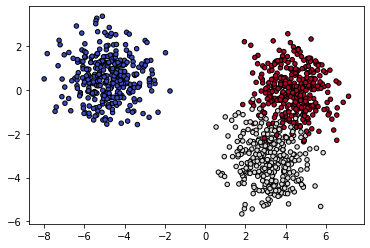

In [57]:
plt.scatter(X[:,0 ], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [58]:
model = GaussianNB()
model.fit(X, y)

GaussianNB()

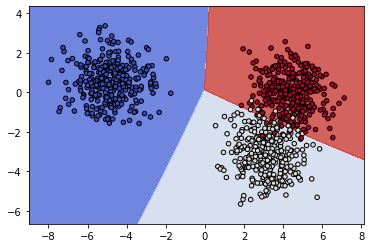

In [59]:
xx, yy = make_meshgrid(X[:, ], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

## 베르누이 나이브 베이즈

* 입력 특성이 베르누이 분포에 의해 생성된 이진 값을 갖는다고 가정

### 학습 및 평가(Count)

In [60]:
model = BernoulliNB()
model.fit(X_train_count, y_train)

BernoulliNB()

In [61]:
predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('Train Accuracy: {}'.format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.7821283365741559
Train F1 Score: [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [69]:
predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy: {}'.format(acc))
print('Test F1 Score: {}'.format(f1))

Test Accuracy: 0.6307753584705258
Test F1 Score: [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


### 학습 및 평가(Hash)

In [71]:
model = BernoulliNB()
model.fit(X_train_hash, y_train)

BernoulliNB()

In [72]:
predict = model.predict(X_train_hash)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('Train Accuracy: {}'.format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.5951917977726711
Train F1 Score: [0.74226804 0.49415205 0.45039019 0.59878155 0.57327935 0.63929619
 0.35390947 0.59851301 0.72695347 0.68123862 0.79809524 0.70532319
 0.54703833 0.66862745 0.61889927 0.74707471 0.6518668  0.60485269
 0.5324165  0.54576271]


In [73]:
predict = model.predict(X_test_hash)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy: {}'.format(acc))
print('Test F1 Score: {}'.format(f1))

Test Accuracy: 0.4430430164630908
Test F1 Score: [0.46678636 0.33826638 0.29391892 0.45743329 0.41939121 0.46540881
 0.34440068 0.46464646 0.62849873 0.53038674 0.63782051 0.55251799
 0.32635983 0.34266886 0.46105919 0.61780105 0.46197991 0.54591837
 0.27513228 0.3307888 ]


### 학습 및 평가(Tf-idf)

In [74]:
model = BernoulliNB()
model.fit(X_train_tfidf, y_train)

BernoulliNB()

In [75]:
predict = model.predict(X_train_tfidf)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('Train Accuracy: {}'.format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.7821283365741559
Train F1 Score: [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [76]:
predict = model.predict(X_test_tfidf)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy: {}'.format(acc))
print('Test F1 Score: {}'.format(f1))

Test Accuracy: 0.6307753584705258
Test F1 Score: [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


### 시각화

In [77]:
X, y = make_blobs(n_samples=1000)

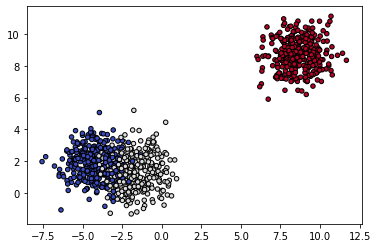

In [78]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [79]:
model = BernoulliNB()
model.fit(X, y)

BernoulliNB()

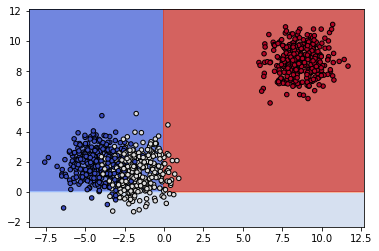

In [81]:
xx, yy = make_meshgrid(X[:, 0], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

## 다항 나이브 베이즈

* 입력 특성이 다항분포에 의해 생성된 빈도수 값을 갖는다고 가정

### 학습 및 평가 (Count)

In [82]:
model = MultinomialNB()
model.fit(X_train_count, y_train)

MultinomialNB()

In [84]:
predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('Train Accuracy: {}'.format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.9245182959165635
Train F1 Score: [0.95228426 0.904      0.25073746 0.81402003 0.96669513 0.88350983
 0.90710383 0.97014925 0.98567818 0.99325464 0.98423237 0.95399516
 0.95703454 0.98319328 0.98584513 0.95352564 0.97307002 0.97467249
 0.95157895 0.86526946]


In [86]:
predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Train Accuracy: {}'.format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.7728359001593202
Train F1 Score: [0.77901431 0.7008547  0.00501253 0.64516129 0.79178082 0.73370166
 0.76550681 0.88779285 0.93951094 0.91390728 0.94594595 0.78459938
 0.72299169 0.84635417 0.86029412 0.80846561 0.78665077 0.89281211
 0.60465116 0.48695652]


### 학습 및 평가(Tf-idf)

In [87]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [88]:
predict = model.predict(X_train_tfidf)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('Train Accuracy: {}'.format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.9326498143892522
Train F1 Score: [0.87404162 0.95414462 0.95726496 0.92863002 0.97812773 0.97440273
 0.91090909 0.97261411 0.98659966 0.98575021 0.98026316 0.94033413
 0.9594478  0.98032506 0.97755611 0.77411003 0.93506494 0.97453907
 0.90163934 0.45081967]


In [89]:
predict = model.predict(X_test_tfidf)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Train Accuracy: {}'.format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.7738980350504514
Train F1 Score: [0.63117871 0.72       0.72778561 0.72104019 0.81309686 0.81643836
 0.7958884  0.88135593 0.93450882 0.91071429 0.92917167 0.73583093
 0.69732938 0.81907433 0.86559803 0.60728118 0.76286353 0.92225201
 0.57977528 0.24390244]


### 시각화

In [112]:
X, y = make_blobs(n_samples=1000)

In [113]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

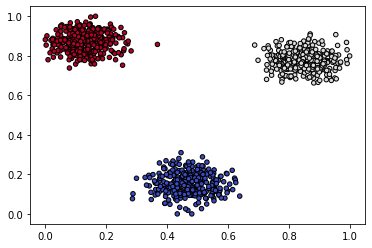

In [114]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [115]:
model = MultinomialNB()
model.fit(X, y)

MultinomialNB()

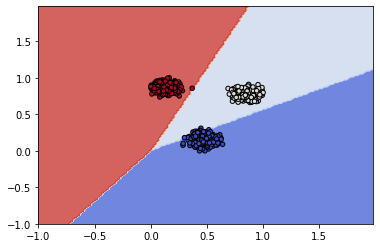

In [116]:
xx, yy = make_meshgrid(X[:, 0], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')